In [133]:
import scipy.optimize
import xarray as xr
import pandas as pd
import matplotlib
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import sys
import cftime
import datetime
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list, lat_lon_coord_slice
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
from isca_tools.cesm.load import jasmin_archive_dir, jasmin_surf_geopotential_file
import copy
import os

print(os.getcwd())
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [48]:
data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_time'
exp_name = ['pre_industrial', 'co2_2x']
co2_vals = [1, 2]
n_exp = len(exp_name)
ds = [xr.load_dataset(os.path.join(data_dir, exp_name[i], 'output.nc')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))

In [127]:
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
lsm = (xr.open_dataset(invariant_data_path).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)
ds['ZREFHT'] = cesm.load.load_z2m(invariant_data_path, var_reindex_like=ds.PS)

In [137]:
ds['P'] = cesm.get_pressure(ds.PS, ds.P0.isel(co2=0), ds.hyam.isel(co2=0), ds.hybm.isel(co2=0))
ds['T500'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0), np.atleast_1d(500*100)).load()
ds['Z500'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0), np.atleast_1d(500*100)).load()
ds['mse_REFHT'] = moist_static_energy(ds.TREFHT, ds.QREFHT, ds.ZREFHT)
ds['mse_low_lev'] = moist_static_energy(ds.T.isel(lev=-1), ds.Q.isel(lev=-1), ds.Z3.isel(lev=-1))
ds['mse_sat_500'] = moist_static_energy(ds.T500, sphum_sat(ds.T500, float(ds.T500.plev)), ds.Z500)

In [212]:
ds['T500_zonal_daily_av_resize'] = ds.T500_zonal_daily_av.where(ds.time_max.dt.floor('D') == ds.time.dt.floor('D')).max(dim='time')

In [213]:
# Compute various measures of LCL
# Physical from REFHT
ds['p_lcl_REFHT'], ds['T_lcl_REFHT'] = lcl_metpy(ds.TREFHT, ds.QREFHT, ds.PS)

# Physical from lowest model level
ds['p_lcl_low_lev'], ds['T_lcl_low_lev'] = lcl_metpy(ds.T.isel(lev=-1), ds.Q.isel(lev=-1), ds.P.isel(lev=-1))

# Effective so no CAPE or CIN at 500hPa from REFHT
ds['Q_eff_REFHT'] = ds['QREFHT'] - (ds.mse_REFHT - ds.mse_sat_500).isel(plev=0) * 1000 / L_v
ds['p_lcl_eff_REFHT'], ds['T_lcl_eff_REFHT'] = lcl_metpy(ds.TREFHT, ds.Q_eff_REFHT, ds.PS)

# Effective so no CAPE or CIN at 500hPa from lowest model level
ds['Q_eff_low_lev'] = ds['Q'].isel(lev=-1) - (ds.mse_low_lev - ds.mse_sat_500).isel(plev=0) * 1000 / L_v
ds['p_lcl_eff_low_lev'], ds['T_lcl_eff_low_lev'] = lcl_metpy(ds.T.isel(lev=-1), ds.Q_eff_low_lev, ds.P.isel(lev=-1))

## Specific Locations
Look at the temperature and MSE profile at specific locations.

In [476]:
loc_lat = [59.84,  40.05, -24.03,  55.13]
loc_lon = [50, 355, 133.75, 290]
loc_lat = [25,  0.05, -24.03,  55.13]
loc_lon = [50, 355, 133.75, 290]
ds_loc = lat_lon_coord_slice(ds, loc_lat, loc_lon)
ds_loc = ds_loc.rename({"location": "loc"})
ds_loc = ds_loc.assign_coords(loc=['russia', 'spain', 'australia', 'canada'])

In [477]:
def apply_func_vec(func, n_lev_args, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    # n_lev_args is the number of arguments (ignoring pressure) with a plev dimension. The non plev args must be given first
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * (len(args)-n_lev_args) + [['lev']] * (n_lev_args + 1),
                          output_core_dims=[['lev']], vectorize=True, dask='parallelized', output_dtypes=[float])

def conv_neutral_profile(temp_lcl, p_lcl, p):
    if np.isnan(temp_lcl):
        return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

def mse_env_profile(p_lcl, q_refht, temp_env, z_env, p):
    # MSE profile maintains surface specific humifity up to LCL then is saturated
    mse_profile = moist_static_energy(temp_env, sphum_sat(temp_env, p), z_env)
    # Replace values below the LCL with MSE using q_refht
    mask = p >= p_lcl
    mse_profile = xr.where(mask, moist_static_energy(temp_env, q_refht, z_env), mse_profile)
    return mse_profile

In [478]:
ds_loc['T_sqe_REFHT'] = apply_func_vec(conv_neutral_profile, 0, ds_loc.P, ds_loc.T_lcl_REFHT, ds_loc.p_lcl_REFHT)
ds_loc['T_sqe_low_lev'] = apply_func_vec(conv_neutral_profile, 0, ds_loc.P, ds_loc.T_lcl_low_lev, ds_loc.p_lcl_low_lev)
ds_loc['T_sqe_eff_REFHT'] = apply_func_vec(conv_neutral_profile, 0, ds_loc.P, ds_loc.T_lcl_eff_REFHT, ds_loc.p_lcl_eff_REFHT)
ds_loc['T_sqe_eff_low_lev'] = apply_func_vec(conv_neutral_profile, 0, ds_loc.P, ds_loc.T_lcl_eff_low_lev, ds_loc.p_lcl_eff_low_lev)

In [479]:
ds_loc['mse_env_REFHT'] = apply_func_vec(mse_env_profile, 2, ds_loc.P, ds_loc.p_lcl_REFHT, ds_loc.QREFHT, ds_loc.T, ds_loc.Z3)
ds_loc['mse_env_low_lev'] = apply_func_vec(mse_env_profile, 2, ds_loc.P, ds_loc.p_lcl_low_lev, ds_loc.Q.isel(lev=-1), ds_loc.T, ds_loc.Z3)

ds_loc['mse_env_eff_REFHT'] = apply_func_vec(mse_env_profile, 2, ds_loc.P, ds_loc.p_lcl_eff_REFHT, ds_loc.Q_eff_REFHT, ds_loc.T, ds_loc.Z3)
ds_loc['mse_env_eff_low_lev'] = apply_func_vec(mse_env_profile, 2, ds_loc.P, ds_loc.p_lcl_eff_low_lev, ds_loc.Q_eff_low_lev, ds_loc.T, ds_loc.Z3)

ds_loc['mse_eff_REFHT'] = moist_static_energy(ds_loc.TREFHT, ds_loc.Q_eff_REFHT, ds_loc.ZREFHT)
ds_loc['mse_eff_low_lev'] = moist_static_energy(ds_loc.T.isel(lev=-1), ds_loc.Q_eff_low_lev, ds_loc.Z3.isel(lev=-1))

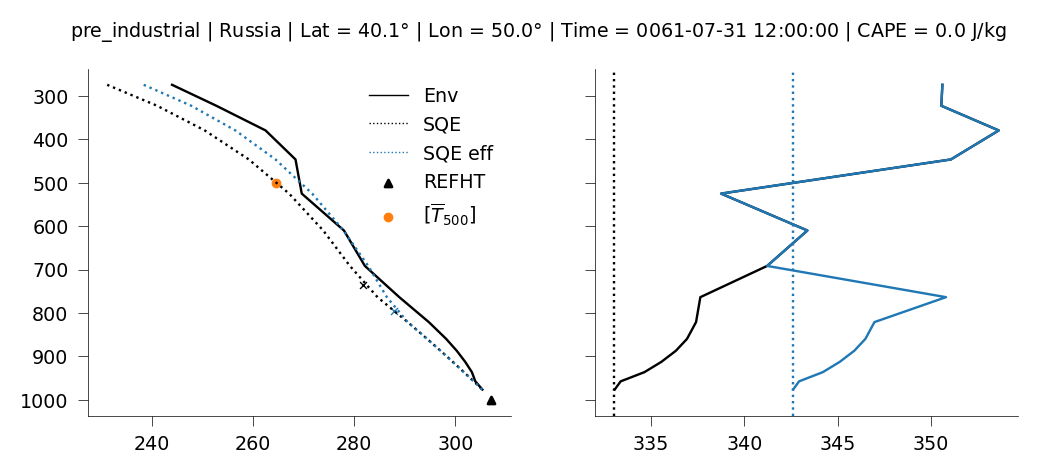

In [480]:
loc_plot = 'russia'
# sqe_plot = 'REFHT'
sqe_plot = 'low_lev'
co2_ind = 0
ds_use = ds_loc.isel(co2=co2_ind).sel(loc=loc_plot).isel(lev=slice(16, -1))
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 6)
ax[0].plot(ds_use.T, ds_use.P/100, color='k', label='Env')
ax[0].plot(ds_use[f'T_sqe_{sqe_plot}'], ds_use.P/100, color='k', linestyle=':', label='SQE')
ax[0].plot(ds_use[f'T_sqe_eff_{sqe_plot}'], ds_use.P/100, color='C0', linestyle=':', label='SQE eff')
ax[0].scatter(ds_use[f'T_lcl_{sqe_plot}'], ds_use[f'p_lcl_{sqe_plot}']/100, marker='x', color='k')
ax[0].scatter(ds_use[f'T_lcl_eff_{sqe_plot}'], ds_use[f'p_lcl_eff_{sqe_plot}']/100, marker='x', color='C0')
ax[0].scatter(ds_use.TREFHT, ds_use.PS/100, marker='^', color='k', label='REFHT')
ax[0].scatter(ds_use.T500_zonal_daily_av_resize, 500, marker='o', color='C1', label='$[\overline{T}_{500}]$')

ax[1].plot(ds_use[f'mse_env_{sqe_plot}'], ds_use.P/100, color='k')
ax[1].axvline(ds_use[f'mse_{sqe_plot}'], color='k', linestyle=':')
ax[1].plot(ds_use[f'mse_env_eff_{sqe_plot}'], ds_use.P/100, color='C0')
ax[1].axvline(ds_use[f'mse_eff_{sqe_plot}'], color='C0', linestyle=':')
ax[0].invert_yaxis()
time_str = str(ds_use.time_max.values.item())[:19]
fig.suptitle(
    f'{exp_name[co2_ind]} | {loc_plot.capitalize()} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$ |'
    f' Time = {time_str} | CAPE = {ds_use.CAPE:.1f} J/kg', y=0.99, fontsize=9)
ax[0].legend()
update_fontsize(fig)
update_linewidth(fig)
plt.show()

## Global distribution of SQE error in fitting
There are a few regions where the effective SQE is a better fit in the way envisiged e.g. Pursian Gulf.

In [325]:
ds['T_sqe_low_lev'] = apply_func_vec(conv_neutral_profile, 0, ds.P, ds.T_lcl_low_lev, ds.p_lcl_low_lev)

In [379]:
%%time
ds['T_sqe_eff_low_lev'] = apply_func_vec(conv_neutral_profile, 0, ds.P, ds.T_lcl_eff_low_lev, ds.p_lcl_eff_low_lev)

CPU times: user 5min 16s, sys: 1.93 s, total: 5min 18s
Wall time: 5min 21s


In [ ]:
idx = np.abs(ds.T - ds['T_sqe_eff_low_lev']).where(ds.p>300*100).argmax(dim='lev')

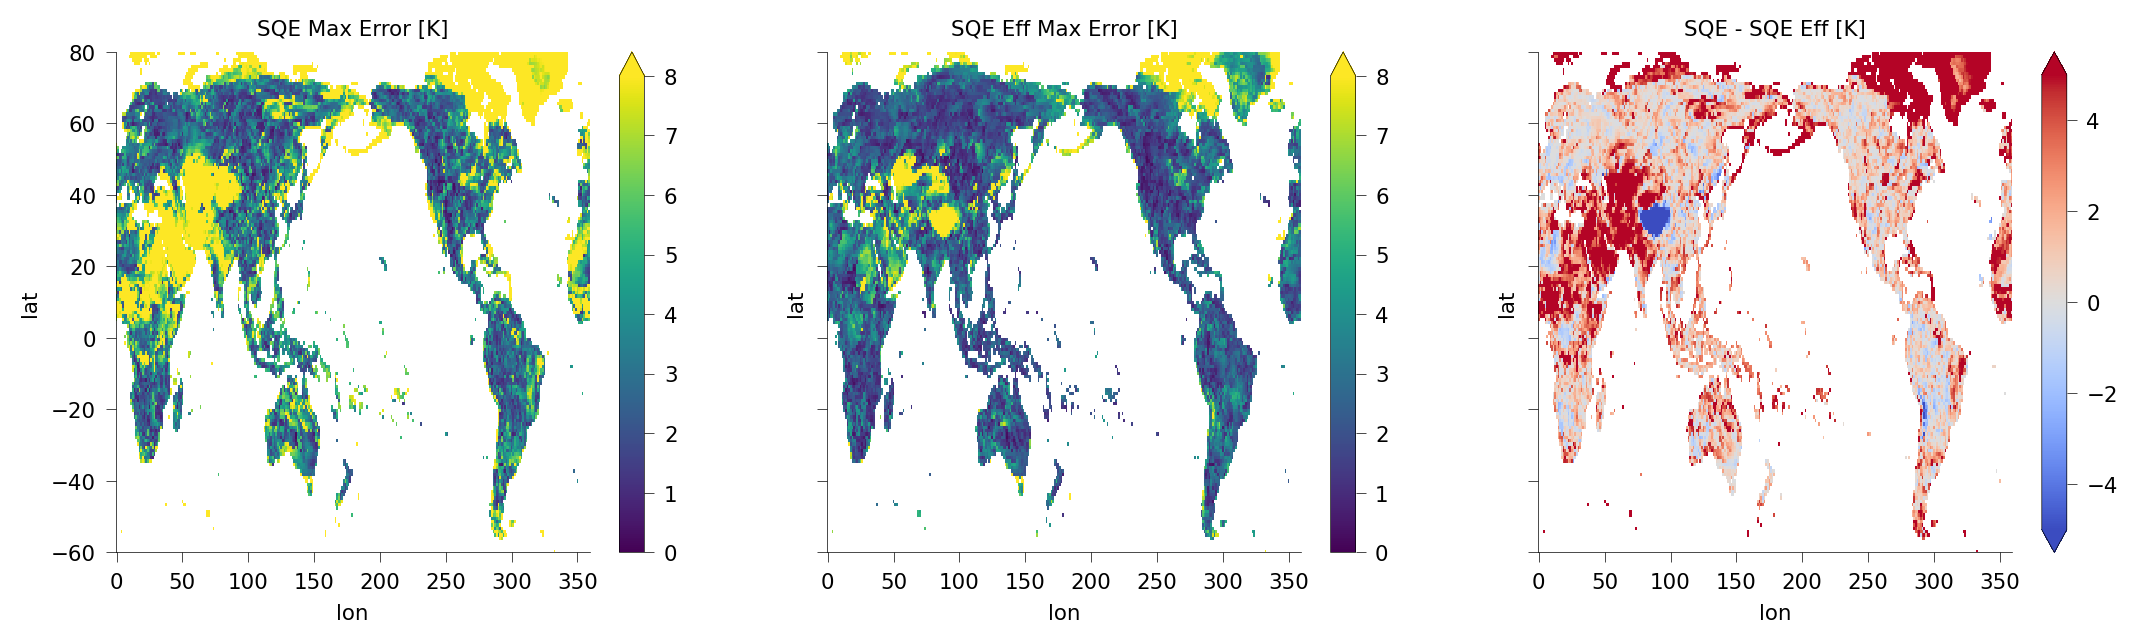

In [491]:
co2_ind = 0
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
isca_tools.plot.fig_resize(fig, 13)
idx = np.abs(ds.T - ds['T_sqe_low_lev']).where(ds.p>300*100).argmax(dim='lev')
var = []
var.append(np.abs(ds.T - ds['T_sqe_low_lev']).isel(lev=idx).isel(co2=co2_ind).where(lsm))
var[0].plot(vmin=0, vmax=8, cmap='viridis', ax=ax[0])
idx = np.abs(ds.T - ds['T_sqe_eff_low_lev']).where(ds.p>300*100).argmax(dim='lev')
var.append(np.abs(ds.T - ds['T_sqe_eff_low_lev']).isel(lev=idx).isel(co2=co2_ind).where(lsm))
var[1].plot(vmin=0, vmax=8, cmap='viridis', ax=ax[1])
(var[0]-var[1]).plot(vmin=-5, vmax=5, cmap='coolwarm', ax=ax[2])
ax[0].set_title('SQE Max Error [K]')
ax[1].set_title('SQE Eff Max Error [K]')
ax[2].set_title('SQE - SQE Eff [K]')
ax[0].set_ylim(-60, 80)
update_fontsize(fig)
plt.show()

### Effective LCL location
In regions where the effective LCL is closer to the surface than the physical (red below), there is an often a reduction in the error shown above.
Red regions in the two plots are similar.

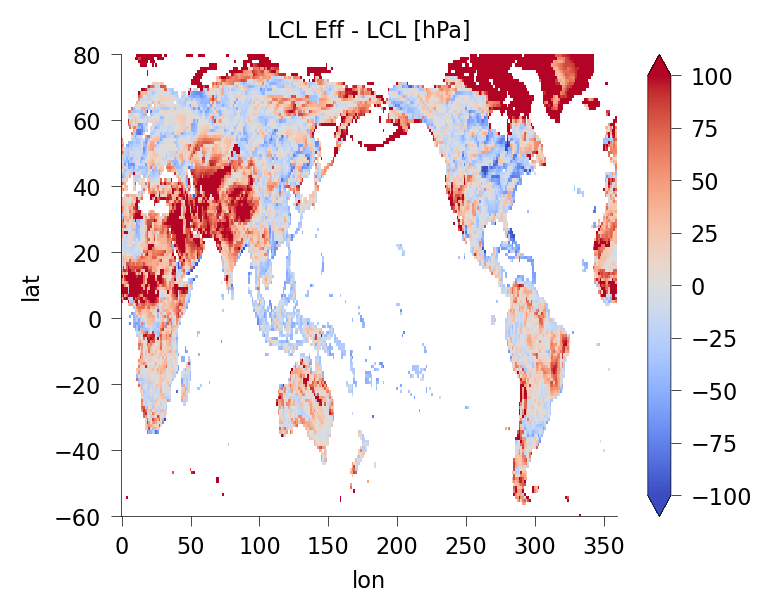

In [505]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True)
isca_tools.plot.fig_resize(fig, 4)
(ds.p_lcl_eff_low_lev/100 - ds.p_lcl_low_lev/100).isel(co2=0).where(lsm).plot(vmin=-100, vmax=100, cmap='coolwarm', ax=ax)
ax.set_ylim(-60, 80)
update_fontsize(fig)
ax.set_title('LCL Eff - LCL [hPa]')
plt.show()

### Individual profiles
Below we plot individual environmental temperature profiles relative to the SQE profile.

In [593]:
error_sqe_eff = np.abs(ds.T - ds['T_sqe_eff_low_lev']).where(ds.p>300*100).max(dim='lev')
error_sqe = np.abs(ds.T - ds['T_sqe_low_lev']).where(ds.p>300*100).max(dim='lev')
# use = np.logical_and(error_sqe_eff < 3, error_sqe - error_sqe_eff > 3)            # effective SQE is good
use = error_sqe_eff > 5                                                             # effective SQE is bad
co2_ind = 1
ds_use = [(ds.T - ds['T_sqe_low_lev']).where(use).isel(co2=co2_ind).where(lsm).sel(lat=slice(-60, 80)),
          (ds.T - ds['T_sqe_eff_low_lev']).where(use).isel(co2=co2_ind).where(lsm).sel(lat=slice(-60, 80)),
          (ds.p_lcl_low_lev/ds.P.isel(lev=-1)).where(use).isel(co2=co2_ind).where(lsm).sel(lat=slice(-60, 80)),
          ds.p.where(use).isel(co2=co2_ind).where(lsm).sel(lat=slice(-60, 80))]
for i in range(len(ds_use)):
    ds_use[i] = ds_use[i].stack(points=("lat", "lon"))
    ds_use[i] = ds_use[i].dropna(dim="points", how="all")

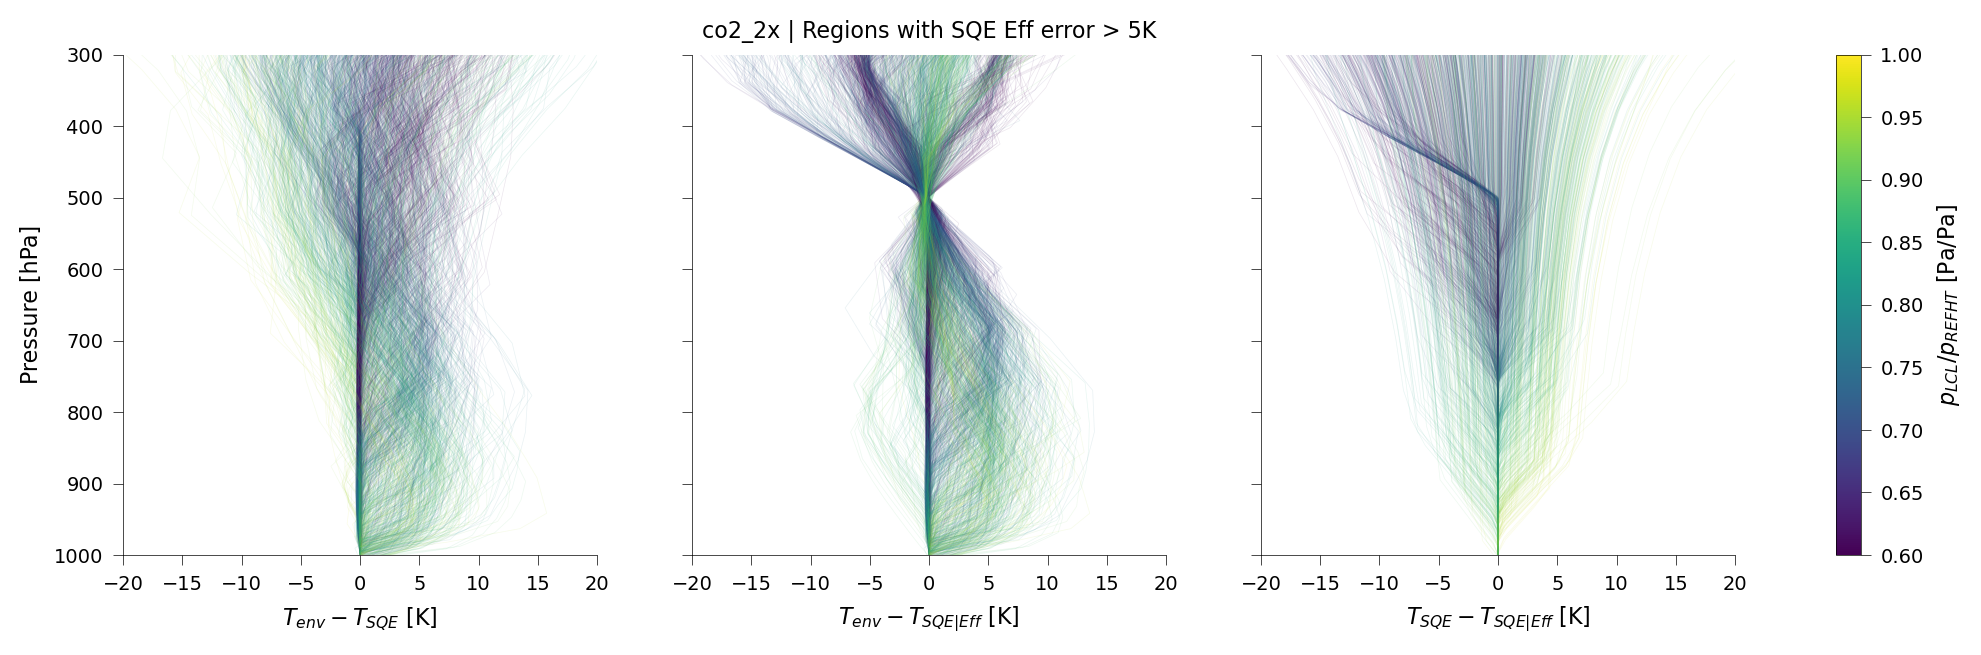

In [594]:
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
isca_tools.plot.fig_resize(fig, 13)

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0.6, vmax=1)

for i in range(ds_use[0].points.size):
    if ds_use[2].isel(points=i) > 1:
        continue            # get rid of regions where LCL is at higher pressure than surface
    if np.abs(ds_use[1].isel(points=i, lev=-1))>0.1:
        continue            # get rid of regions where effective temp different to environmental at surface
    ax[0].plot(ds_use[0].isel(points=i), ds_use[-1].isel(points=i)/100, lw=ax_linewidth, alpha=0.1,
               c=cmap(norm(ds_use[2].isel(points=i))))
    ax[1].plot(ds_use[1].isel(points=i), ds_use[-1].isel(points=i)/100, lw=ax_linewidth, alpha=0.1,
               c=cmap(norm(ds_use[2].isel(points=i))))
    ax[2].plot(ds_use[1].isel(points=i)-ds_use[0].isel(points=i), ds_use[-1].isel(points=i)/100, lw=ax_linewidth, alpha=0.1,
               c=cmap(norm(ds_use[2].isel(points=i))))
ax[0].set_ylim(300, 1000)
ax[0].set_xlim(-20, 20)
ax[0].invert_yaxis()
ax[0].set_xlabel('$T_{env} - T_{SQE}$ [K]')
ax[1].set_xlabel('$T_{env} - T_{SQE|Eff}$ [K]')
ax[2].set_xlabel('$T_{SQE} - T_{SQE|Eff}$ [K]')
ax[1].set_title(f'{exp_name[co2_ind]} | Regions with SQE Eff error > 5K')
# ax[1].set_title(f'{exp_name[co2_ind]} | Regions with SQE Eff error < 3K but SQE error > 6K')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="$p_{LCL}/p_{REFHT}$ [Pa/Pa]", ax=ax.ravel())
ax[0].set_ylabel('Pressure [hPa]')
plt.show()

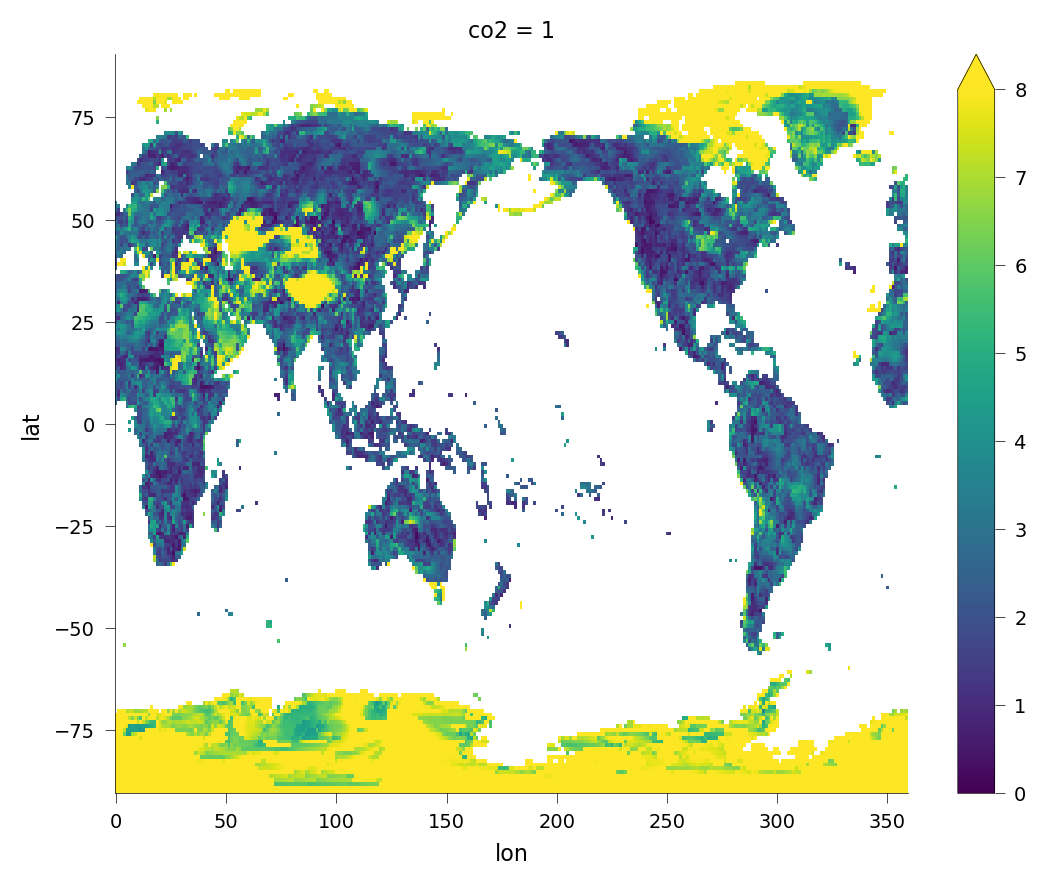

In [440]:
idx = np.abs(ds.T - ds['T_sqe_eff_low_lev']).where(ds.p>300*100).argmax(dim='lev')
np.abs(ds.T - ds['T_sqe_eff_low_lev']).isel(lev=idx).isel(co2=0).where(lsm).plot(vmin=0, vmax=8, cmap='viridis')

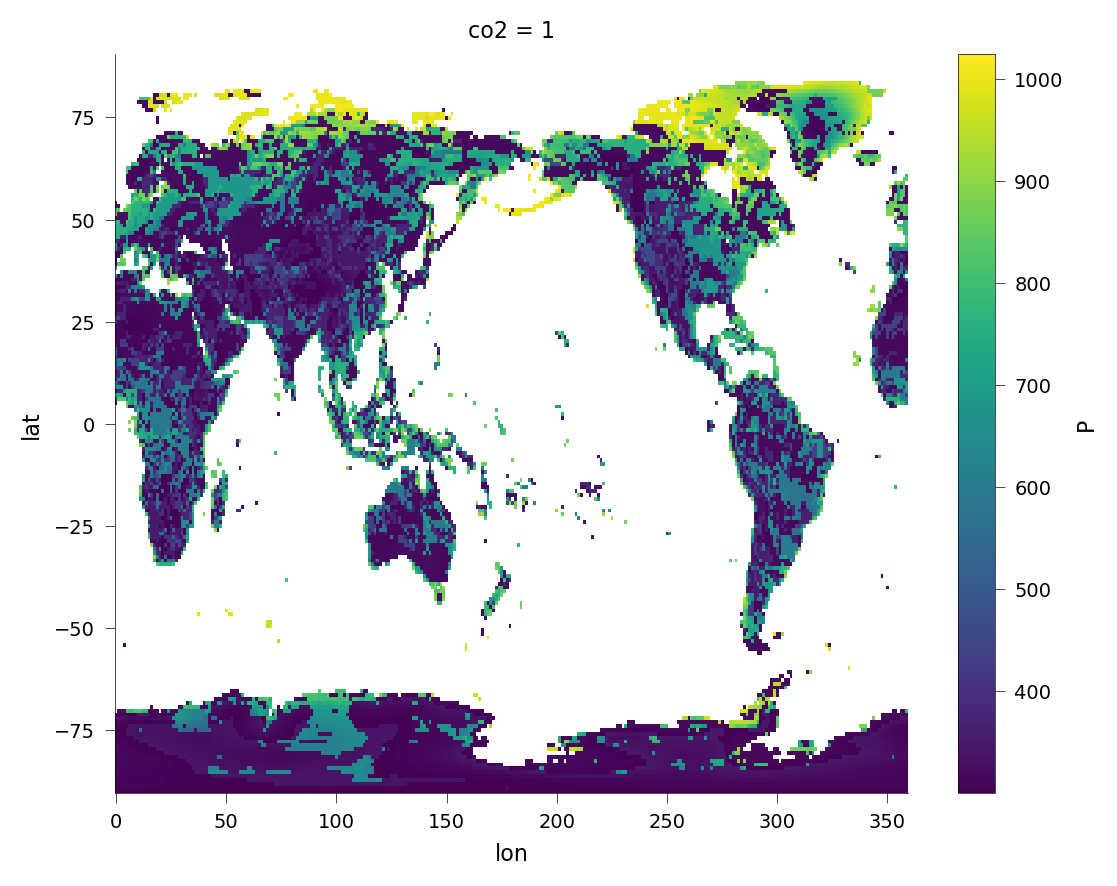

In [433]:
(ds.P/100).isel(lev=idx).isel(co2=0).where(lsm).plot()

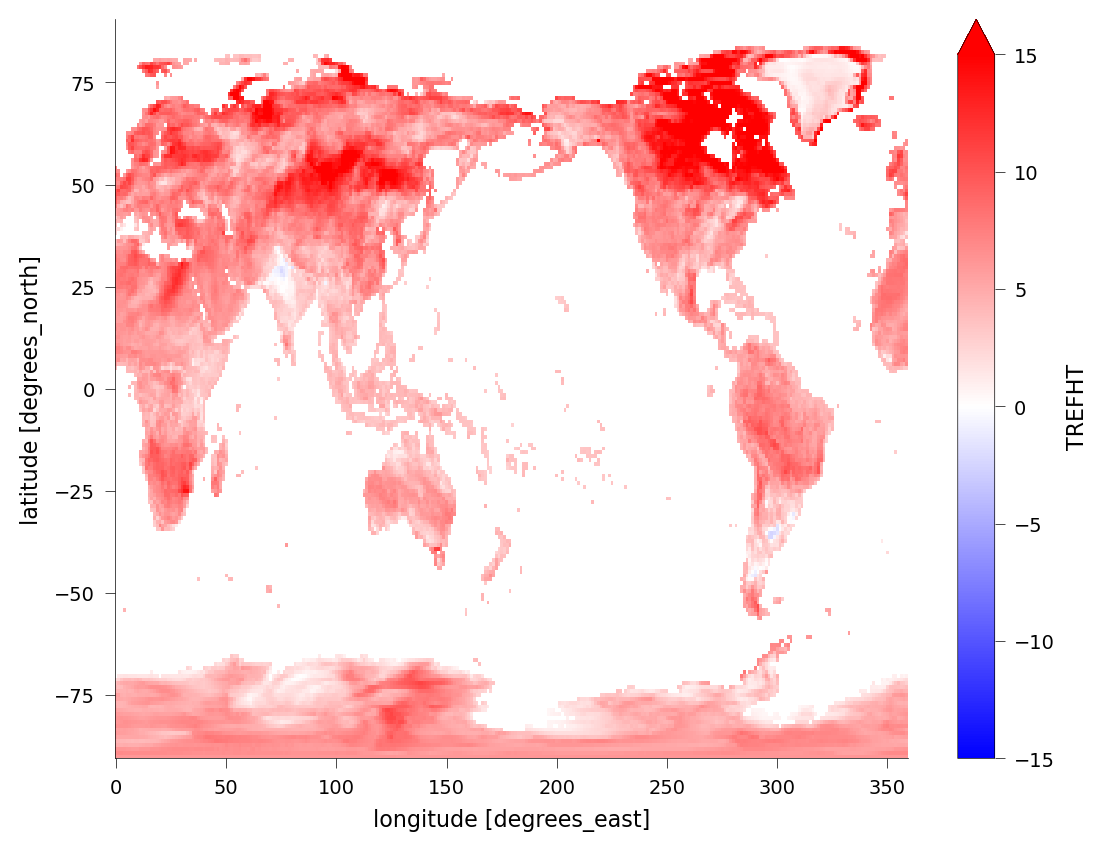

In [55]:
(ds.TREFHT.isel(co2=1)-ds.TREFHT.isel(co2=0)).where(lsm).plot(vmin=-15, vmax=15, cmap='bwr')

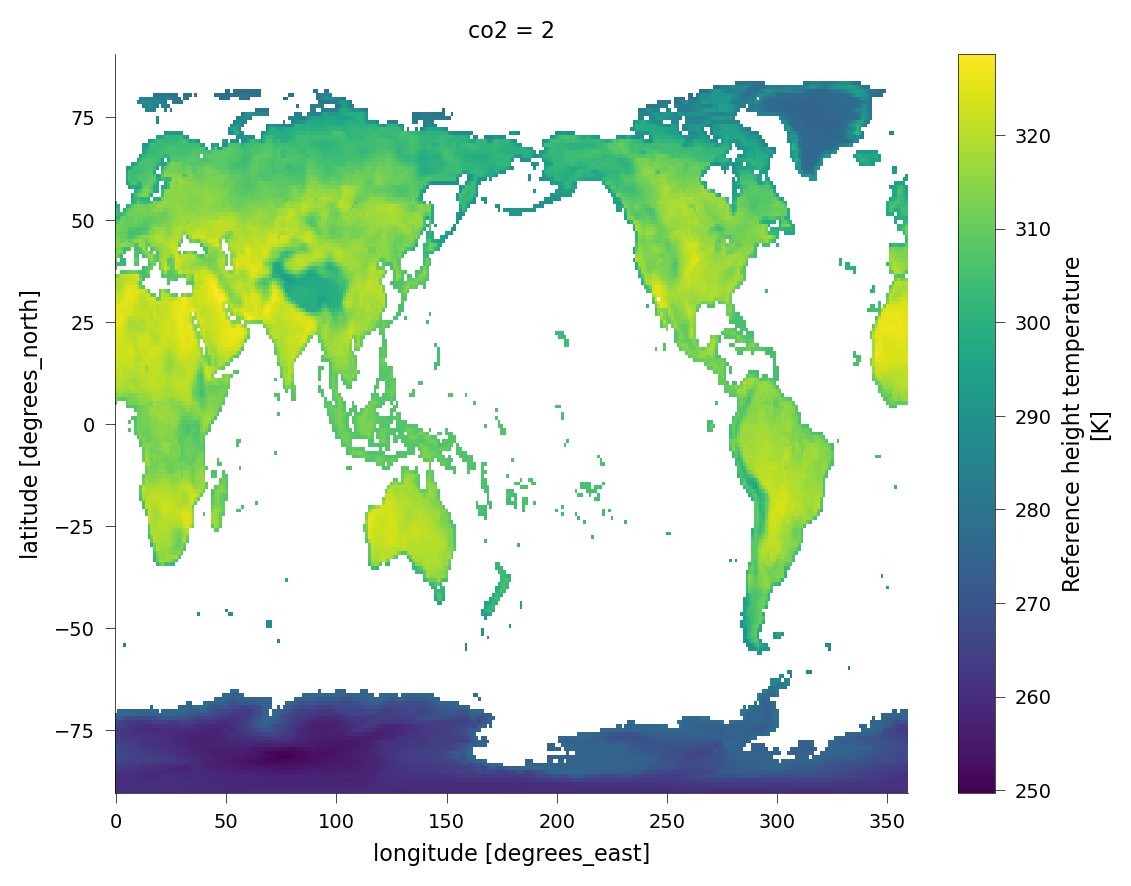

In [78]:
ds.isel(co2=1).TREFHT.where(lsm).plot()

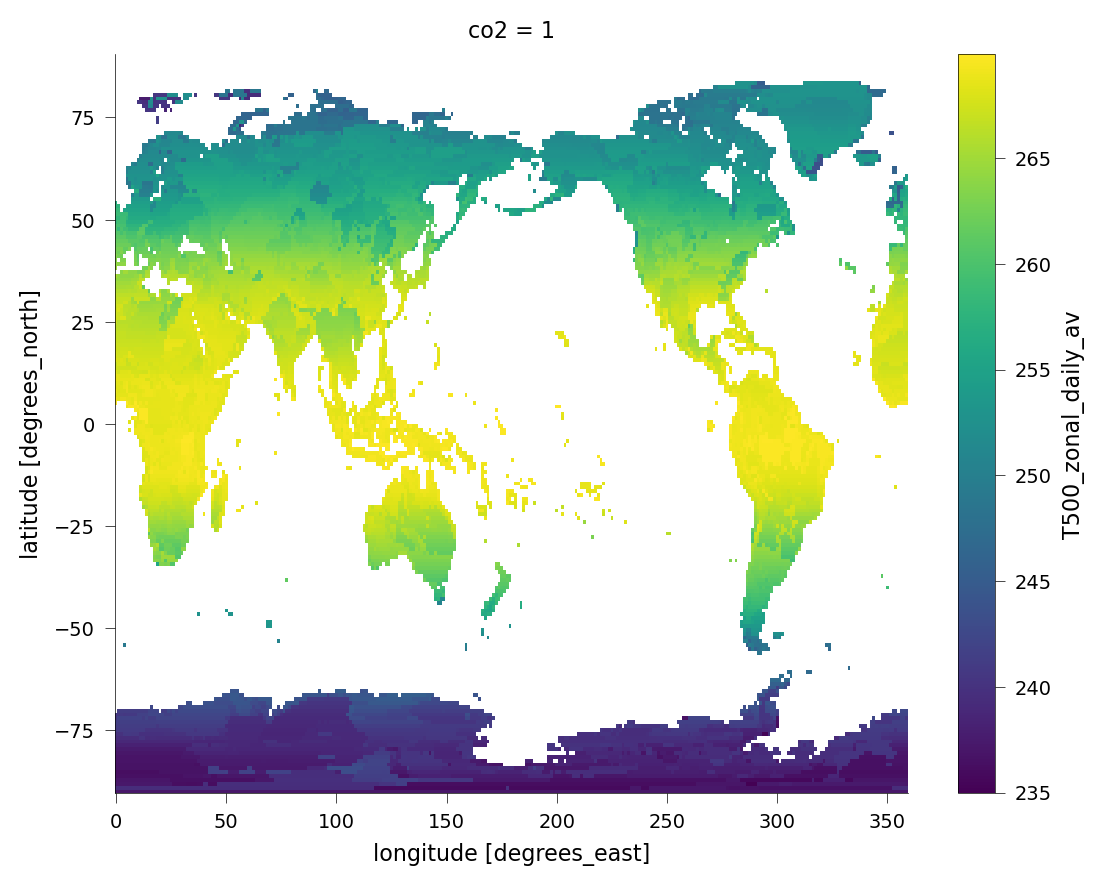

In [83]:
# zonal, daily av T500 at time of max TREFHT - this closely corresponds to day of year below
ds.isel(co2=0).T500_zonal_daily_av.where(ds.isel(co2=0).time_max.dt.floor('D') == ds.time.dt.floor('D')).max(dim='time').where(lsm).plot()

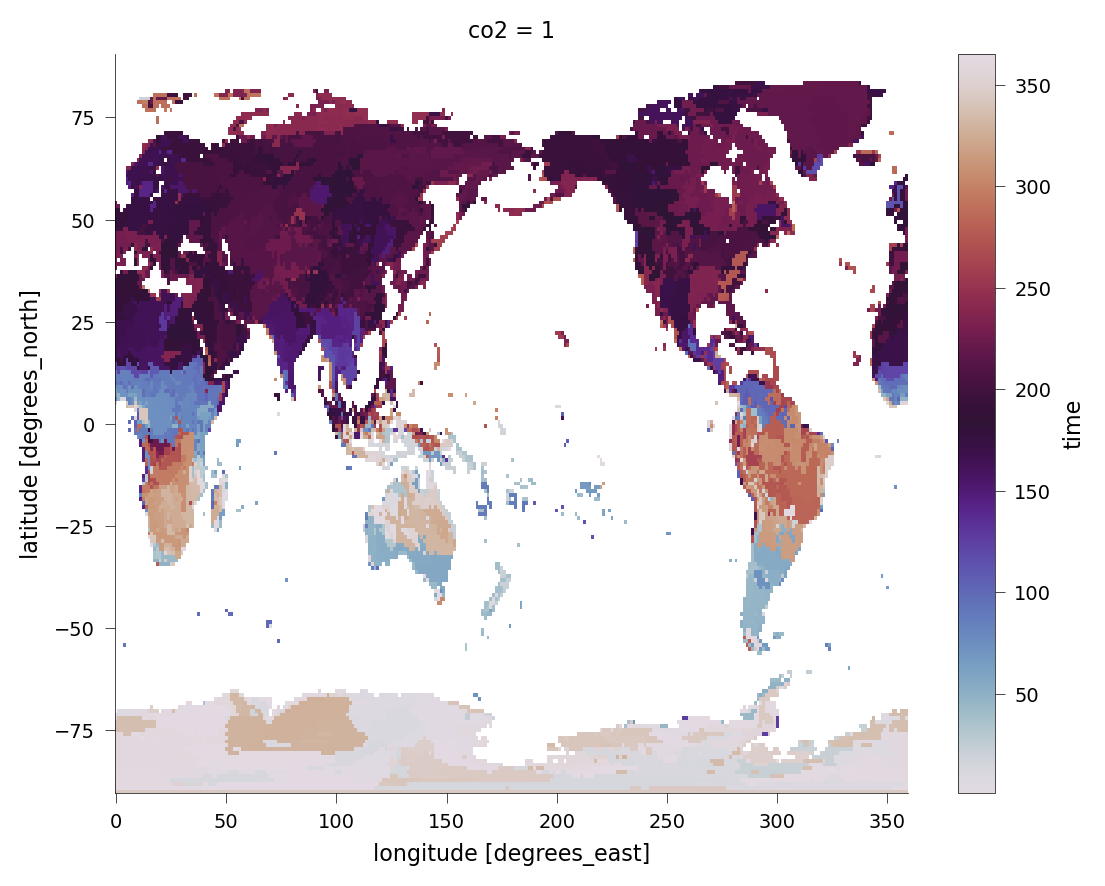

In [82]:
ds.time_max.dt.dayofyear.isel(co2=0).where(lsm).plot(cmap='twilight')